In [9]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=2,
            latent_dims=10,
            n_samples=100,
            shuffle=False,
            periode=p,
            L=288*p,
            min_max=False,
            num_layers=3,
            first_kernel=288)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(56, 63), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

In [10]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = args.enc_out**2 
args.robust = False
vae = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
vq = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

vae = vae.to(args.device)
vq = vq.to(args.device)

opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

(1310,)


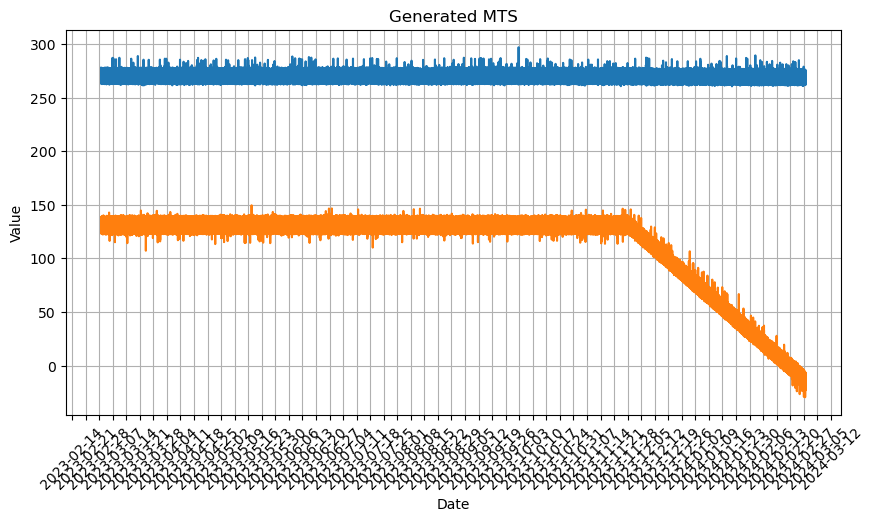

In [11]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="both",
                                                                            occurance=2,
                                                                            return_gen=True,
                                                                            anomalies=True)

In [12]:
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(vae, train_data_long, args, keep_norm=False)
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

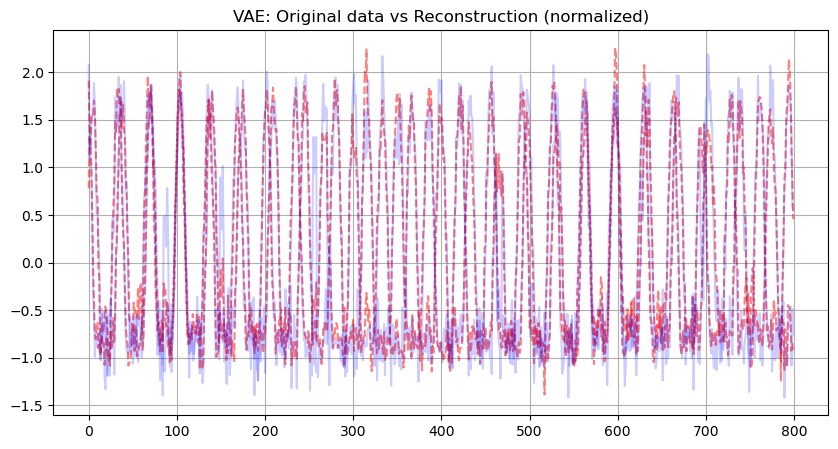

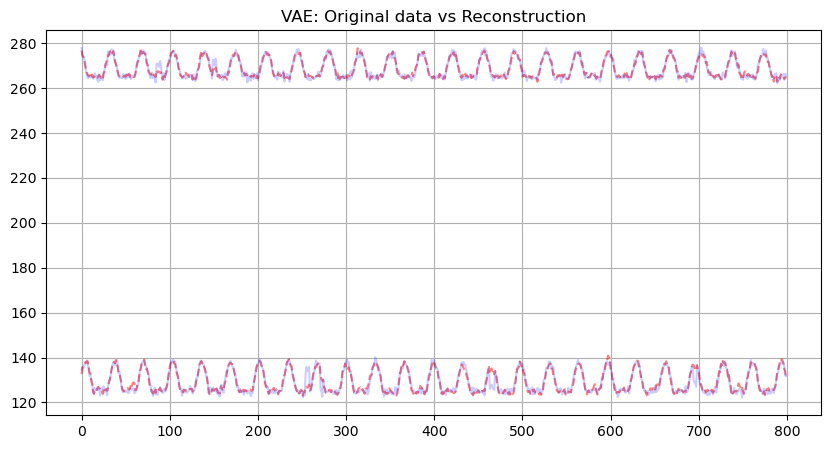

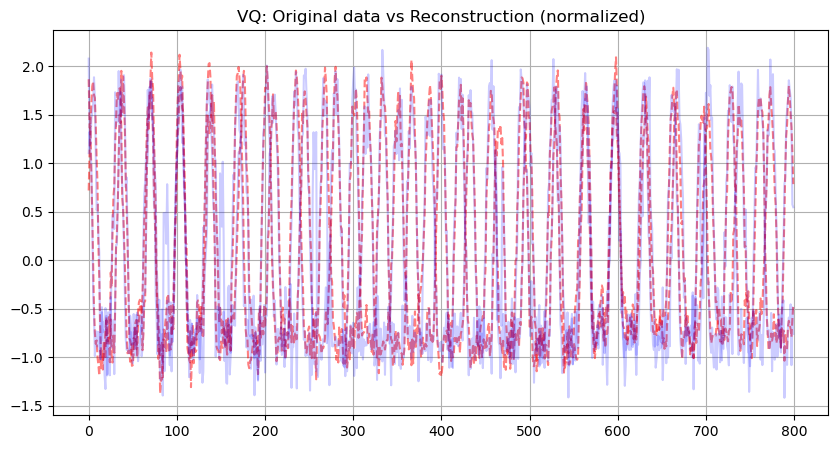

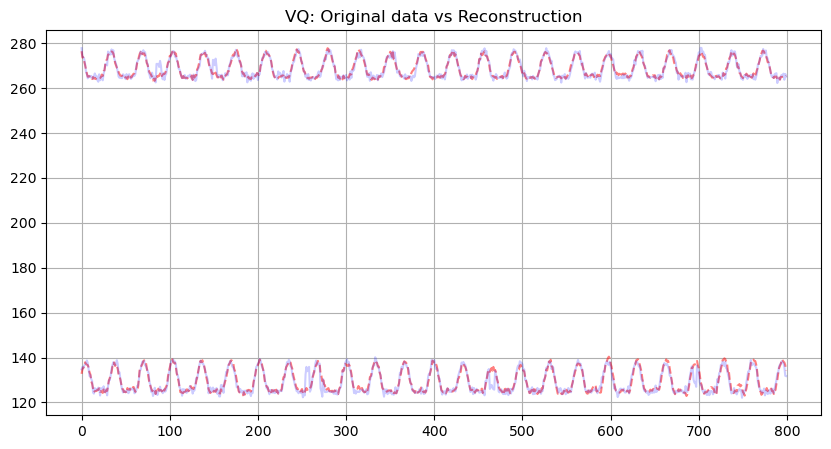

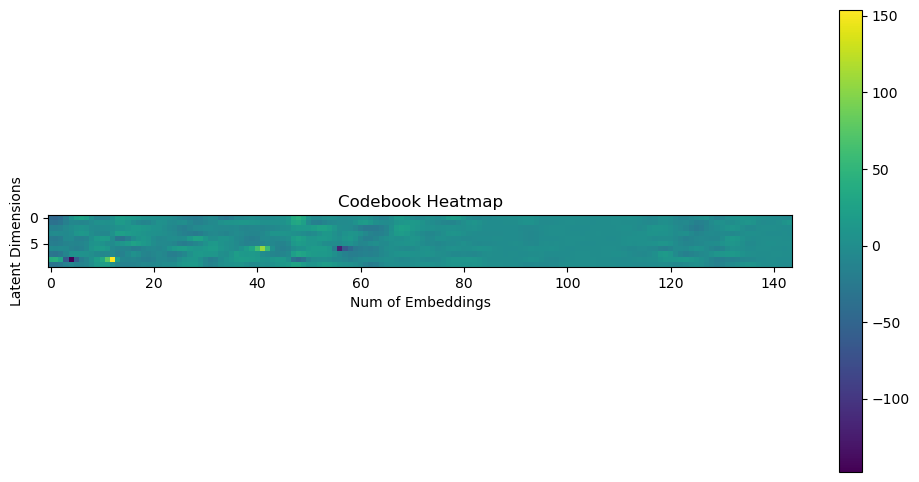

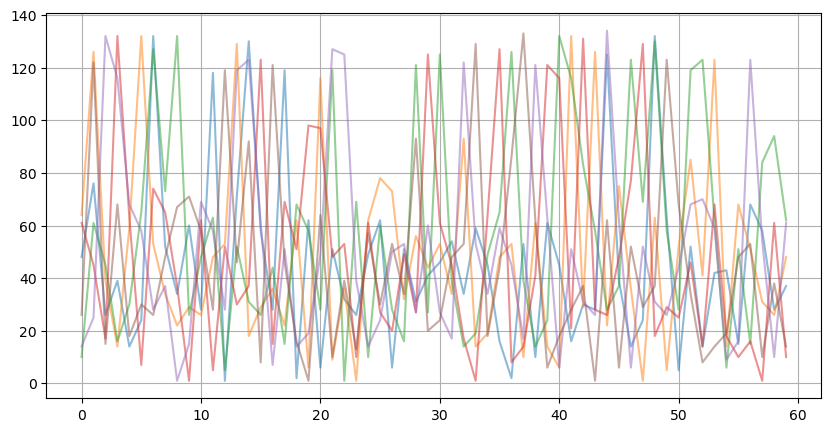

====> VAE: Sample 401 Average loss: 0.7728
====> VQ: Sample 401 Average loss: 1.3082
Train Epoch: 402 [0/1 (0%)]	Loss: 112.125162	 True Loss: 16258.148438
Train Epoch: 402 [0/1 (0%)]	Loss: 189.510789	 True Loss: 27479.064453
====> VAE: Sample 402 Average loss: 0.7733
====> VQ: Sample 402 Average loss: 1.3070
Train Epoch: 403 [0/1 (0%)]	Loss: 112.568063	 True Loss: 16322.369141
Train Epoch: 403 [0/1 (0%)]	Loss: 184.440921	 True Loss: 26743.933594
====> VAE: Sample 403 Average loss: 0.7763
====> VQ: Sample 403 Average loss: 1.2720
Train Epoch: 404 [0/1 (0%)]	Loss: 112.231506	 True Loss: 16273.568359
Train Epoch: 404 [0/1 (0%)]	Loss: 181.647320	 True Loss: 26338.861328
====> VAE: Sample 404 Average loss: 0.7740
====> VQ: Sample 404 Average loss: 1.2527
Train Epoch: 405 [0/1 (0%)]	Loss: 110.778381	 True Loss: 16062.865234
Train Epoch: 405 [0/1 (0%)]	Loss: 185.990207	 True Loss: 26968.580078
====> VAE: Sample 405 Average loss: 0.7640
====> VQ: Sample 405 Average loss: 1.2827
Train Epoch: 40

Train Epoch: 439 [0/1 (0%)]	Loss: 104.543609	 True Loss: 15158.823242
Train Epoch: 439 [0/1 (0%)]	Loss: 196.940948	 True Loss: 28556.437500
====> VAE: Sample 439 Average loss: 0.7210
====> VQ: Sample 439 Average loss: 1.3582
Train Epoch: 440 [0/1 (0%)]	Loss: 104.365470	 True Loss: 15132.993164
Train Epoch: 440 [0/1 (0%)]	Loss: 186.062419	 True Loss: 26979.050781
====> VAE: Sample 440 Average loss: 0.7198
====> VQ: Sample 440 Average loss: 1.2832
Train Epoch: 441 [0/1 (0%)]	Loss: 103.442861	 True Loss: 14999.214844
Train Epoch: 441 [0/1 (0%)]	Loss: 180.187446	 True Loss: 26127.179688
====> VAE: Sample 441 Average loss: 0.7134
====> VQ: Sample 441 Average loss: 1.2427
Train Epoch: 442 [0/1 (0%)]	Loss: 103.115908	 True Loss: 14951.806641
Train Epoch: 442 [0/1 (0%)]	Loss: 188.021202	 True Loss: 27263.074219
====> VAE: Sample 442 Average loss: 0.7111
====> VQ: Sample 442 Average loss: 1.2967
Train Epoch: 443 [0/1 (0%)]	Loss: 103.572973	 True Loss: 15018.081055
Train Epoch: 443 [0/1 (0%)]	Lo

Train Epoch: 477 [0/1 (0%)]	Loss: 97.308607	 True Loss: 14109.748047
Train Epoch: 477 [0/1 (0%)]	Loss: 186.119195	 True Loss: 26987.283203
====> VAE: Sample 477 Average loss: 0.6711
====> VQ: Sample 477 Average loss: 1.2836
Train Epoch: 478 [0/1 (0%)]	Loss: 96.576980	 True Loss: 14003.662109
Train Epoch: 478 [0/1 (0%)]	Loss: 194.817915	 True Loss: 28248.597656
====> VAE: Sample 478 Average loss: 0.6660
====> VQ: Sample 478 Average loss: 1.3436
Train Epoch: 479 [0/1 (0%)]	Loss: 96.456822	 True Loss: 13986.239258
Train Epoch: 479 [0/1 (0%)]	Loss: 185.411746	 True Loss: 26884.703125
====> VAE: Sample 479 Average loss: 0.6652
====> VQ: Sample 479 Average loss: 1.2787
Train Epoch: 480 [0/1 (0%)]	Loss: 96.894269	 True Loss: 14049.668945
Train Epoch: 480 [0/1 (0%)]	Loss: 187.253138	 True Loss: 27151.705078
====> VAE: Sample 480 Average loss: 0.6682
====> VQ: Sample 480 Average loss: 1.2914
Train Epoch: 481 [0/1 (0%)]	Loss: 96.027546	 True Loss: 13923.994141
Train Epoch: 481 [0/1 (0%)]	Loss: 1

In [13]:
args.min_max= False
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []

for epoch in range(1, 500):
    loss_vae = train(vae, train_data_long, args, opt_vae, epoch)
    loss_vq = train(vq, train_data_long, args, opt_vq, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        show_results_long(vae, train_data_long, args)
        show_results_long(vq, train_data_long, args, vq=True)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
                
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data_long.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data_long.dataset)))

In [14]:
def get_anomalies_labels(X, model, data, args, norm=False, group_size=3):
    
    x, params, e_params = X.parameters()
    Origin, REC, _ = rebuild_TS_non_overlapping(model, data, args, keep_norm=norm)

    channels = e_params['Pulse']["channel"][0]
    indexes = e_params['Pulse']["index"][0]
    
    #Create a mask for the anomalies
    n_train = Origin.shape[0]
    mask = np.full(x.squeeze().shape, False)
    mask[channels, indexes] = True
    mask = mask[:, :n_train]
    
    # Reduce the size of mask (grouped values)
    reshaped_mask = mask.reshape(2, -1, group_size)
    
    # Get labels
    labels = np.any(reshaped_mask, axis=2)
    
    return labels

In [32]:
def get_anomalies_prediction(X, model, data, args, norm=True, threshold=0.03, group_size=3):
    
    x, params, e_params = X.parameters()
    Origin, REC, _ = rebuild_TS_non_overlapping(model, data, args, keep_norm=norm)
#     plt.plot(Origin.shape)
#     plt.plot(REC)
    
    # Calculate rec loss
    rec_loss = (REC - Origin)**2
    
    #Create a mask for the anomalies
    anomalies_mask = np.full(Origin.T.shape, False)
    for channel in range(args.n_channels):
        anomalies = np.where(rec_loss[:, channel] > threshold)[0]
        anomalies_mask[channel, anomalies] = True

    # Reduce the size of mask (grouped values)
    anomalies_reshaped_mask = anomalies_mask.reshape(args.n_channels, -1, group_size)
    predictions = np.any(anomalies_reshaped_mask, axis=2)
    
    return predictions

(83520,)
82996
0.9912835249042146
0.6239300045362253
0.6308723789156963
(49955,)


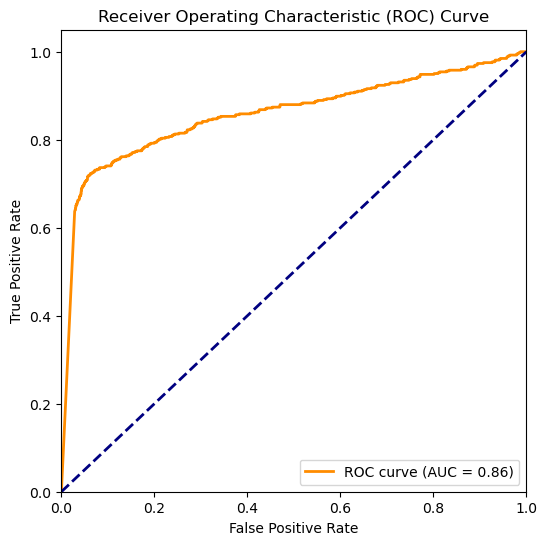

(83520,)
83008
0.9839679118773946
0.8987627698535081
0.6875559666805686
(69915,)


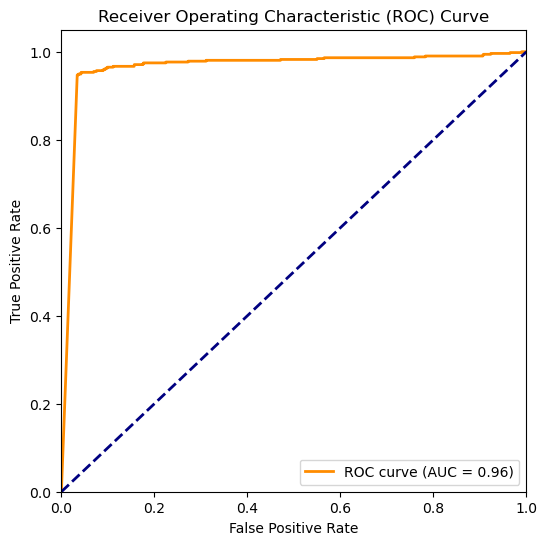

In [68]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
vae_labels = get_anomalies_labels(X_long, vq, train_data_long, args, norm=False, group_size=1)
vae_predictions = get_anomalies_prediction(X_long, vq, train_data_long, args, norm=False, group_size=1, threshold=40)

for i, (label, pred) in enumerate(zip(vae_labels, vae_predictions)):
    print(label.shape)
    print(len(np.where(label==False)[0]))
    accuracy = accuracy_score(label, pred)
    print(accuracy)
    recall = recall_score(label.T, pred.T, average='macro')
    print(recall)
    f1 = f1_score(label.T, pred.T, average='macro')
    print(f1)

    fpr, tpr, thresholds = roc_curve(label, y_scores[i], drop_intermediate=False)
    print(tpr.shape)
    roc_auc = auc(fpr, tpr)   # roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


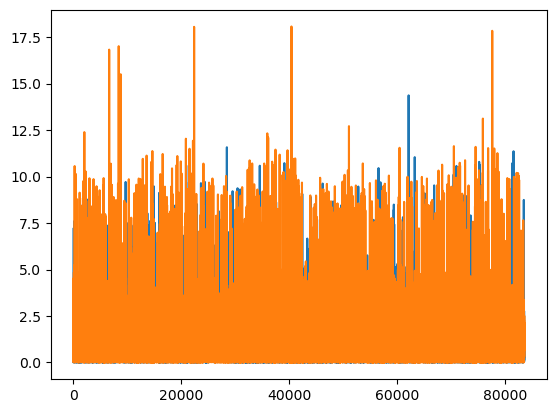

In [29]:
Origin, REC, _ = rebuild_TS_non_overlapping(vq, train_data_long, args, keep_norm=False)
plt.plot(abs(Origin-REC))
    
    # Calculate rec loss
# rec_loss = (REC - Origin)**2
# plt.plot(rec_loss)

In [ ]:
vae_labels = get_anomalies_labels(X_long, vae, train_data_long, args)
vae_predictions = get_anomalies_prediction(X_long, vae, train_data_long, args)
vae_predictions.shape

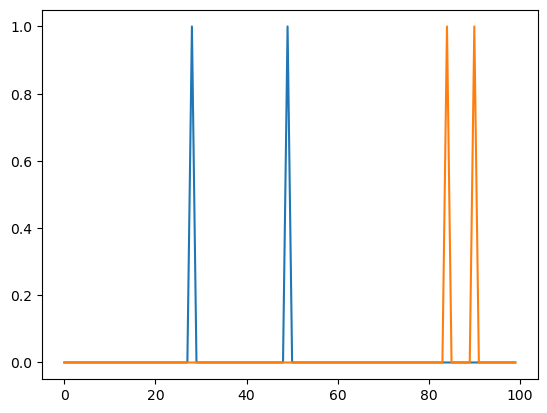

In [159]:
plt.plot(vae_labels.T[:100])

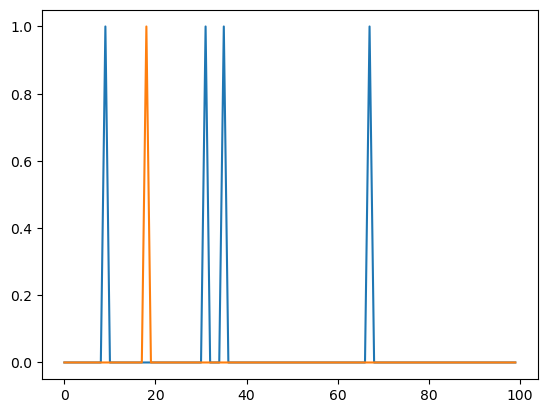

In [141]:
plt.plot(vae_predictions.T[:100])

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.903


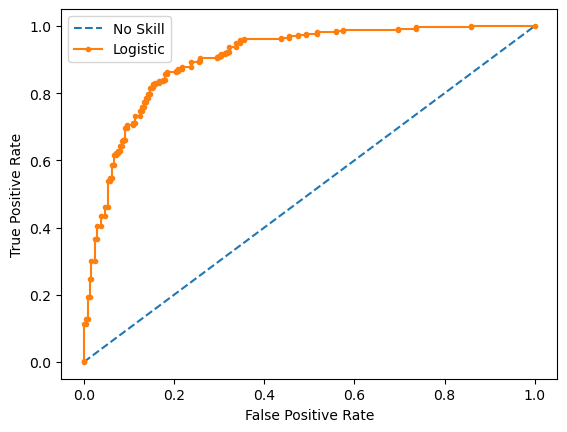

In [1]:
import matplotlib.pyplot as plt
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [67]:
from sklearn.mixture import GaussianMixture
y_scores = []
for i in range(args.n_channels):
    gmm = GaussianMixture(n_components=2, random_state=0)  # You can adjust the number of components
    gmm.fit(rec_loss[:,i].reshape(-1, 1))

    # Get the estimated probabilities of being in each component
    outlier_probabilities = gmm.predict_proba(rec_loss[:,i].reshape(-1, 1))[:, 0]  # Probability of being in the first component
    y_scores.append(1-outlier_probabilities)

In [57]:
outlier_probabilities.shape

(83520,)

In [58]:
rec_loss.shape

torch.Size([83520, 2])

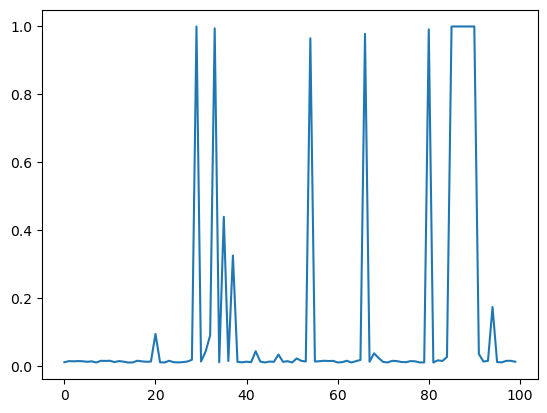

In [64]:
plt.plot(1-outlier_probabilities[:100])